<a href="https://colab.research.google.com/github/PratikChaturvedi/ews_landslide/blob/master/OpenWeatherMapAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Geo geographical coordinates using OSM Nominatim service

More details on using Nominatim API

https://nominatim.org/release-docs/develop/api/Search/

In [22]:
cities = [
    ["Gangtok", "India", "27.33", "88.61"],
    ["Darjeeling", "India","27.04", "88.266" ],
    ["Tawang", "India","27.6325", "91.7539" ],
    ["Tezpur", "India","26.6528", "92.7926" ]

]

In [23]:
df = pd.DataFrame(cities, columns=["city", "country", "latitude", "longitude"])

In [24]:
df

,city,country,latitude,longitude
0,Gangtok,India,27.33,88.61
1,Darjeeling,India,27.04,88.266
2,Tawang,India,27.6325,91.7539
3,Tezpur,India,26.6528,92.7926


# Get weather data

https://openweathermap.org/api/one-call-3

Go to https://home.openweathermap.org/api_keys to get Openweathermap API key

In [25]:
from getpass import getpass
openweathermap_api_key = getpass('Enter Openweathermap API key: ')

Enter Openweathermap API key: ··········


In [26]:
import datetime

def get_weather(row):

  owm_url = f"https://api.openweathermap.org/data/2.5/weather?lat={row.latitude}&lon={row.longitude}&appid={openweathermap_api_key}"
  owm_response = requests.get(owm_url)
  owm_response_json = owm_response.json()
  sunset_utc = datetime.datetime.fromtimestamp(owm_response_json["sys"]["sunset"])
  return {
      "temp": owm_response_json["main"]["temp"] - 273.15,
      "description": owm_response_json["weather"][0]["description"],
      "icon": owm_response_json["weather"][0]["icon"],
      "sunset_utc": sunset_utc,
      "sunset_local": sunset_utc + datetime.timedelta(seconds=owm_response_json["timezone"])
  }

df_weather = df.apply(lambda x: get_weather(x), axis=1)
df = pd.concat([df, pd.json_normalize(df_weather)], axis=1)

In [27]:
df

,city,country,latitude,longitude,temp,description,icon,sunset_utc,sunset_local
0,Gangtok,India,27.33,88.61,23.05,few clouds,02d,2023-09-03 12:25:18,2023-09-03 17:55:18
1,Darjeeling,India,27.04,88.266,18.07,scattered clouds,03d,2023-09-03 12:26:27,2023-09-03 17:56:27
2,Tawang,India,27.6325,91.7539,13.86,clear sky,01d,2023-09-03 12:12:57,2023-09-03 17:42:57
3,Tezpur,India,26.6528,92.7926,28.58,clear sky,01d,2023-09-03 12:08:05,2023-09-03 17:38:05


In [28]:
try:
  import geopandas as gpd
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install geopandas
  import geopandas as gpd

In [29]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326)

In [30]:
try:
  import contextily as ctx
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install contextily
  import contextily as ctx

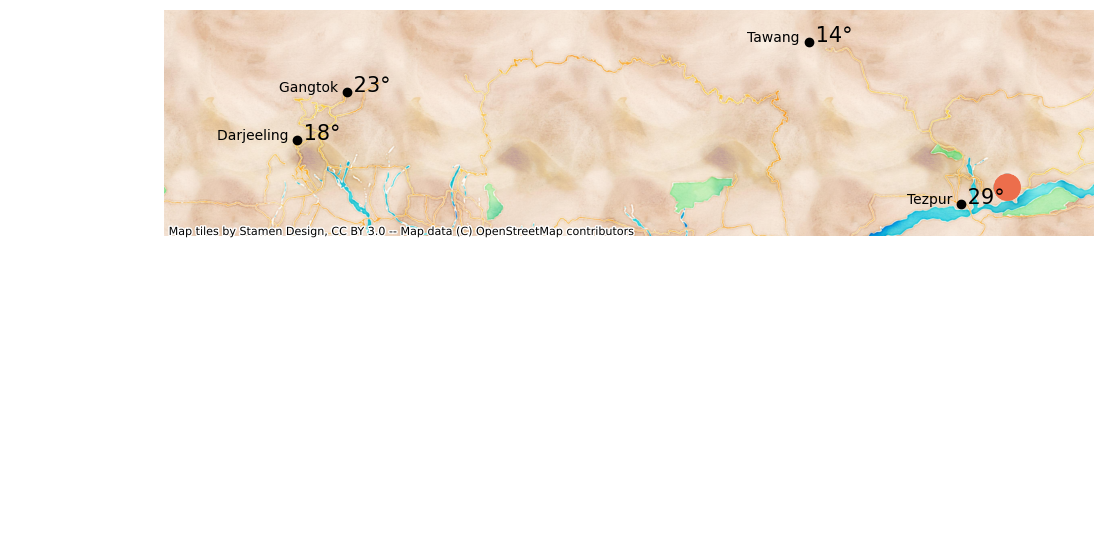

In [31]:
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# plot city location marker
ax = gdf.to_crs(epsg=3857).plot(figsize=(12,8), color="black")

# add weather icon
def add_icon(row):
  img = io.imread(f"https://openweathermap.org/img/wn/{row.icon}@2x.png")
  img_offset = OffsetImage(img, zoom=.4, alpha=1, )
  ab = AnnotationBbox(img_offset, [row.geometry.x+150000, row.geometry.y-110000], frameon=False)
  ax.add_artist(ab)

gdf.to_crs(epsg=3857).apply(add_icon, axis=1)

# add city name label
gdf.to_crs(epsg=3857).apply(lambda x: ax.annotate(text=f"{x.city}  ", fontsize=10, color="black", xy=x.geometry.centroid.coords[0], ha='right'), axis=1);

# add temperature
gdf.to_crs(epsg=3857).apply(lambda x: ax.annotate(text=f" {round(x.temp)}°", fontsize=15, color="black", xy=x.geometry.centroid.coords[0], ha='left'), axis=1);

# add margins
xmin, ymin, xmax, ymax = gdf.to_crs(epsg=3857).total_bounds
margin_y = .2
margin_x = .2
y_margin = (ymax - ymin) * margin_y
x_margin = (xmax - xmin) * margin_x

ax.set_xlim(xmin - x_margin, xmax + x_margin)
ax.set_ylim(ymin - y_margin, ymax + y_margin)

# add basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Watercolor)

ax.set_axis_off()